
# Support Vector Machine


## Initialization: courtesy of Tove

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector  # RFE only works for linear SVM
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, cohen_kappa_score

from collections import Counter
#plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows
from SVM.model import svm_model


In [2]:
data_processor = removeRows("../project_train.csv", rows_to_remove=[69, 85, 95])  # speechiness has an "outlier" as in one datapoint far away from the rest
data_processor.process_rows();
data = data_processor.df


Row 69 will be removed:
danceability          0.715
energy                0.288
key                   1.000
loudness            -13.843
mode                  1.000
speechiness           0.925
acousticness          0.785
instrumentalness      0.000
liveness              0.688
valence               0.772
tempo               115.114
Label                 0.000
Name: 68, dtype: float64

Row 85 will be removed:
danceability         0.4080
energy               0.7140
key                  0.0000
loudness            -6.9420
mode                 1.0000
speechiness          0.0666
acousticness         0.0356
instrumentalness     0.0000
liveness             0.2580
valence              0.7600
tempo               75.3970
Label                1.0000
Name: 85, dtype: float64

Row 95 will be removed:
danceability         0.8060
energy               0.6080
key                  1.0000
loudness            -7.0080
mode                 1.0000
speechiness          0.0659
acousticness         0.0113
instrum

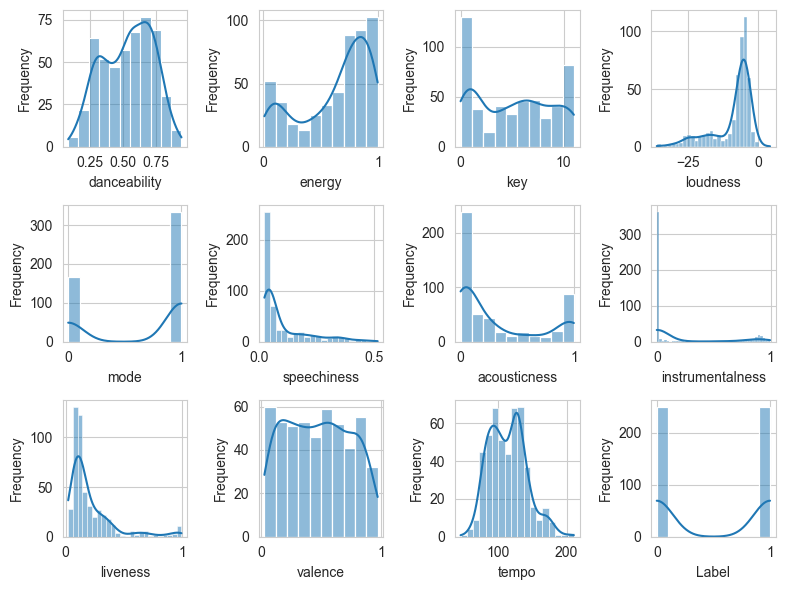

In [3]:
# Check distribution
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
#sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [4]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

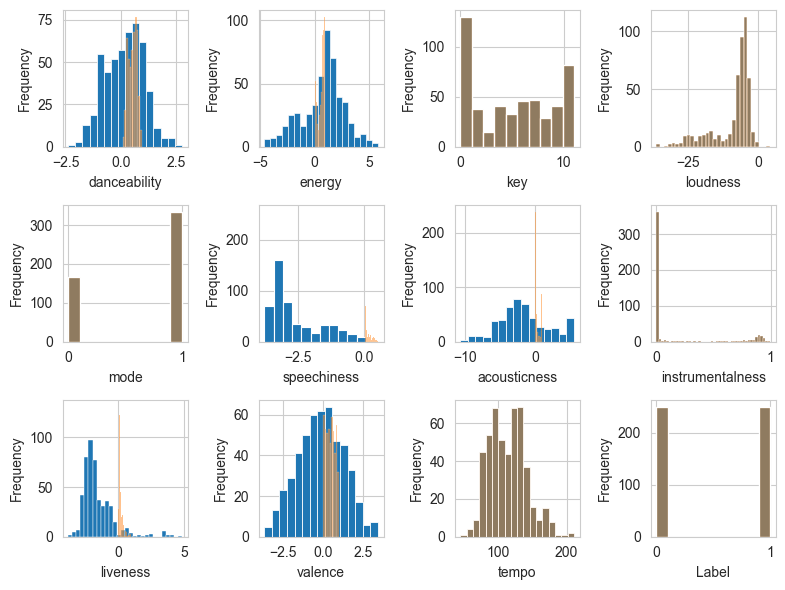

In [5]:
# Check distribution again, comparing transformed (blue) with initial (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(transformed_data[col], ax=axes[i],alpha=1)
    sns.histplot(data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
#sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

In [6]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
#sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

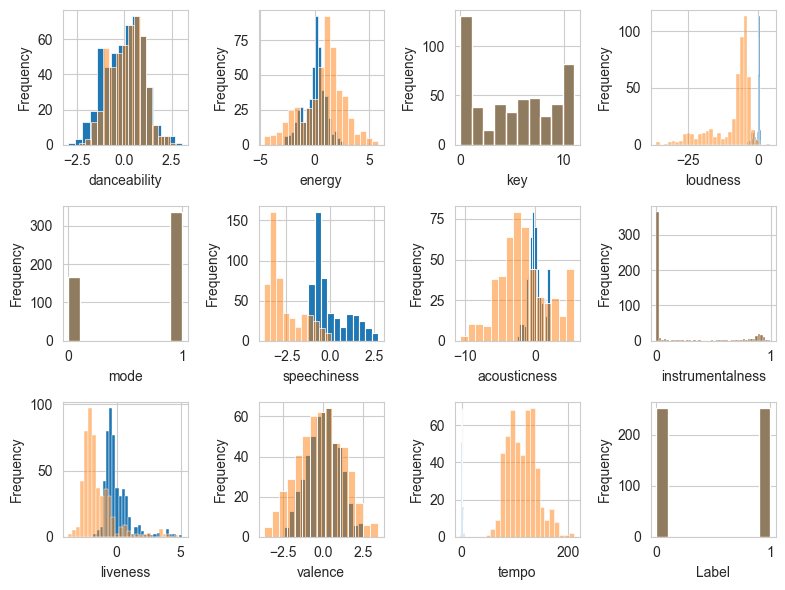

In [7]:
# Check distribution again, comparing scaled (blue) with transformed (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(scaled_data.columns):
    sns.histplot(scaled_data[col], ax=axes[i],alpha=1)
    sns.histplot(transformed_data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=8)

<Axes: >

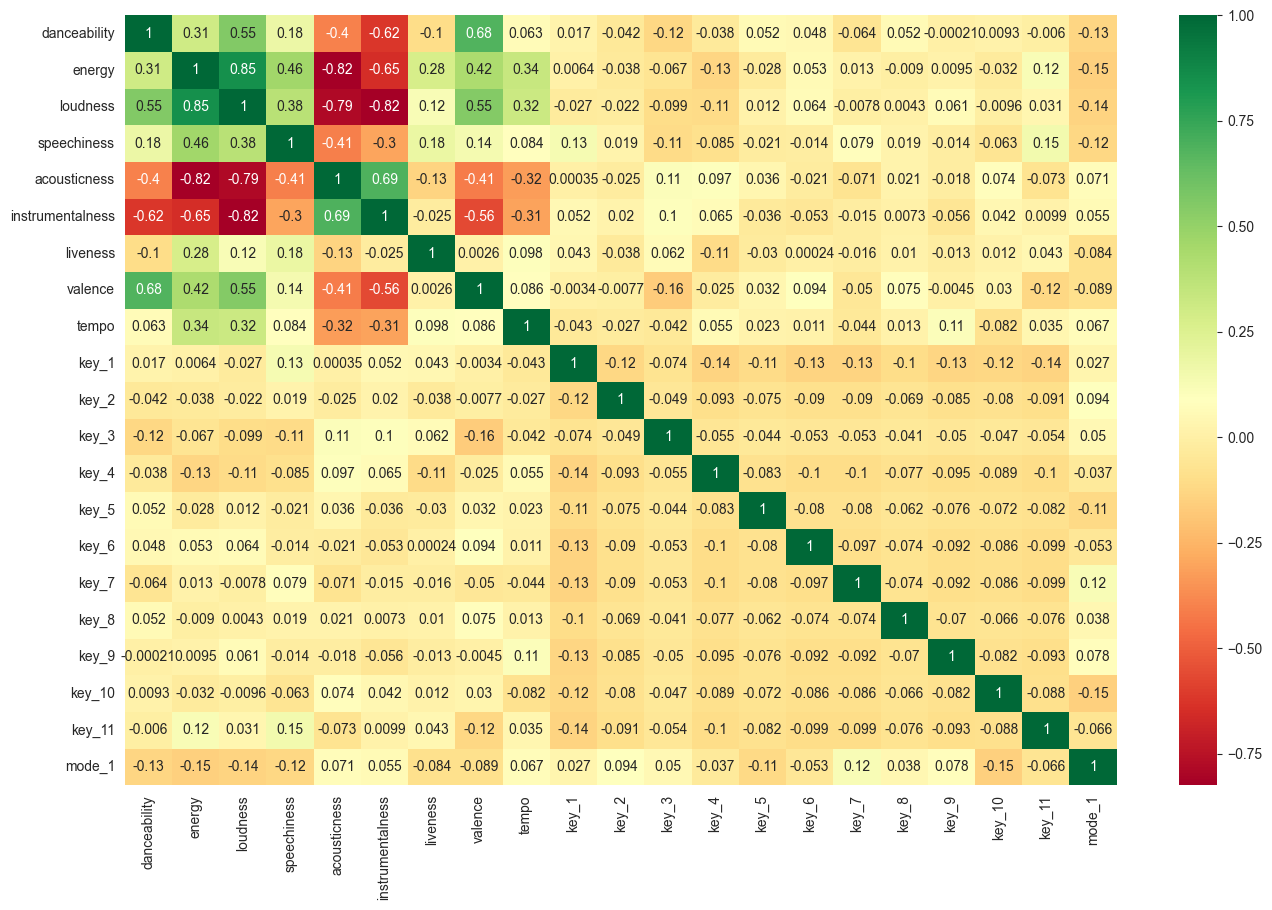

In [9]:
# heat map of correlation
plt.figure(figsize=(16,10))
sns.heatmap(predictors_train.corr(), annot=True, cmap='RdYlGn')

Loudness, acousticness, instrumentalness are probably redundant.

<Axes: >

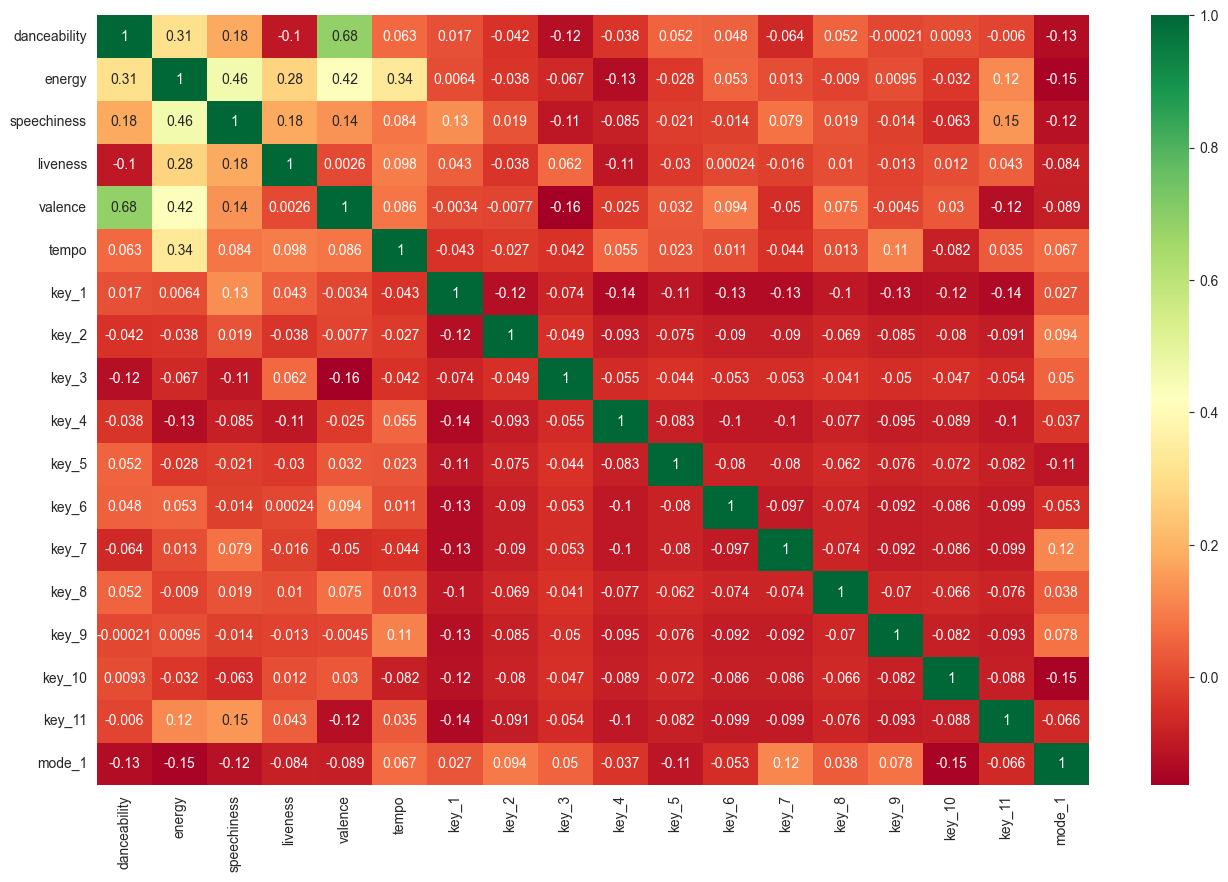

In [10]:
exclude = ['loudness', 'acousticness', 'instrumentalness']
predictors_train_mod = predictors_train.drop(columns=exclude)
plt.figure(figsize=(16, 10))
sns.heatmap(predictors_train_mod.corr(), annot=True, cmap='RdYlGn')

We can see valence is somewhat correlated to danceability, but the rest looks good to me.

In [11]:
predictors_train_mod, predictors_test_mod, response_train_mod, response_test_mod = train_test_split(encoded_data.drop(columns=exclude), response, test_size=0.3, random_state=8)

## Training the SVM
First, a linear SVM is tried

Accuracy: 81.46%
Precision: 83.82%
Recall: 77.03%
Cohen's Kappa Score: 0.63


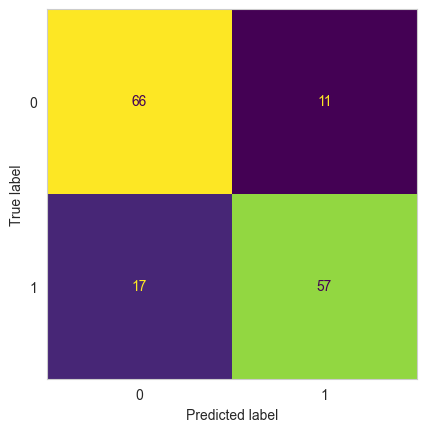

In [12]:
model, _ = svm_model('linear', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 81.46%
Precision: 85.94%
Recall: 74.32%
Cohen's Kappa Score: 0.63


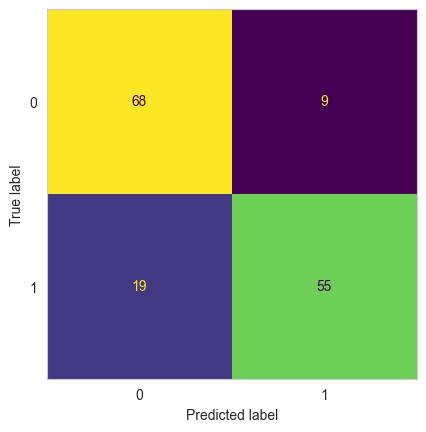

In [13]:
model, _ = svm_model('linear', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

#### Now, a non-linear SVM with rbf (radial basis function) kernel:

Accuracy: 85.43%
Precision: 88.24%
Recall: 81.08%
Cohen's Kappa Score: 0.71


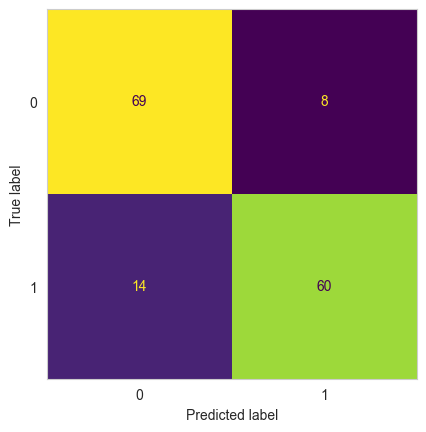

In [14]:
model, _ = svm_model('rbf', predictors_train, response_train, predictors_test, response_test) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test, response_test, colorbar=False, cmap='viridis')
plt.grid(False)

Accuracy: 86.09%
Precision: 88.41%
Recall: 82.43%
Cohen's Kappa Score: 0.72


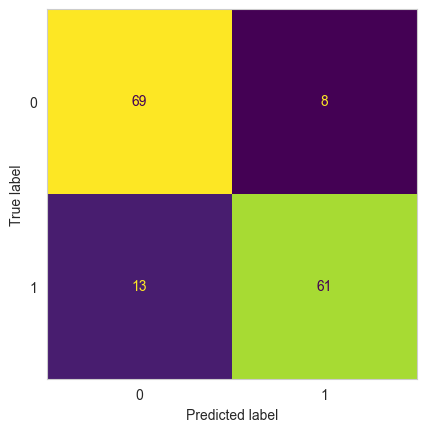

In [15]:
model, _ = svm_model('rbf', predictors_train_mod, response_train_mod, predictors_test_mod, response_test_mod) 

ConfusionMatrixDisplay.from_estimator(model, predictors_test_mod, response_test_mod, colorbar=False, cmap='viridis')
plt.grid(False)

### <span style="color:red">Depending on randomization seed, the results show improvement in accuracy and kappa score for the non-linear SVM compared to linear.</span>

## An attempt at feature optimization 

In [16]:
# Forward sequential
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')


21
With 1 features: Accuracy -- 74.17%, precision: 78.69%, recall: 64.86%, kappa: 0.48
With 2 features: Accuracy -- 79.47%, precision: 80.28%, recall: 77.03%, kappa: 0.59
With 3 features: Accuracy -- 77.48%, precision: 78.57%, recall: 74.32%, kappa: 0.55
With 4 features: Accuracy -- 77.48%, precision: 79.41%, recall: 72.97%, kappa: 0.55
With 5 features: Accuracy -- 83.44%, precision: 86.57%, recall: 78.38%, kappa: 0.67
With 6 features: Accuracy -- 84.11%, precision: 85.71%, recall: 81.08%, kappa: 0.68
With 7 features: Accuracy -- 82.78%, precision: 84.29%, recall: 79.73%, kappa: 0.66
With 8 features: Accuracy -- 82.78%, precision: 84.29%, recall: 79.73%, kappa: 0.66
With 9 features: Accuracy -- 83.44%, precision: 84.51%, recall: 81.08%, kappa: 0.67
With 10 features: Accuracy -- 83.44%, precision: 85.51%, recall: 79.73%, kappa: 0.67
With 11 features: Accuracy -- 83.44%, precision: 85.51%, recall: 79.73%, kappa: 0.67
With 12 features: Accuracy -- 83.44%, precision: 85.51%, recall: 79.73%

In [17]:
# Backward sequential
accuracies = {}
features = {}
for i in range(1, predictors_train.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
    sfs.fit(predictors_train, response_train)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train.loc[:, selected_features]
    predictors_test_sfs = predictors_test.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 74.17%, precision: 78.69%, recall: 64.86%, kappa: 0.48
With 2 features: Accuracy -- 79.47%, precision: 80.28%, recall: 77.03%, kappa: 0.59
With 3 features: Accuracy -- 78.81%, precision: 80.88%, recall: 74.32%, kappa: 0.58
With 4 features: Accuracy -- 83.44%, precision: 86.57%, recall: 78.38%, kappa: 0.67
With 5 features: Accuracy -- 84.11%, precision: 87.88%, recall: 78.38%, kappa: 0.68
With 6 features: Accuracy -- 84.77%, precision: 88.06%, recall: 79.73%, kappa: 0.69
With 7 features: Accuracy -- 84.77%, precision: 88.06%, recall: 79.73%, kappa: 0.69
With 8 features: Accuracy -- 86.09%, precision: 88.41%, recall: 82.43%, kappa: 0.72
With 9 features: Accuracy -- 83.44%, precision: 86.57%, recall: 78.38%, kappa: 0.67
With 10 features: Accuracy -- 84.11%, precision: 85.71%, recall: 81.08%, kappa: 0.68
With 11 features: Accuracy -- 84.77%, precision: 86.96%, recall: 81.08%, kappa: 0.69
With 12 features: Accuracy -- 84.11%, precision: 87.88%, recall: 78.38%, k

In [18]:
# Forward sequential (modified)
accuracies = {}
features = {}
for i in range(1, predictors_train_mod.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i)  # Forward selection process
    sfs.fit(predictors_train_mod, response_train_mod)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
    predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 74.17%, precision: 78.69%, recall: 64.86%, kappa: 0.48
With 2 features: Accuracy -- 79.47%, precision: 80.28%, recall: 77.03%, kappa: 0.59
With 3 features: Accuracy -- 78.81%, precision: 80.88%, recall: 74.32%, kappa: 0.58
With 4 features: Accuracy -- 83.44%, precision: 86.57%, recall: 78.38%, kappa: 0.67
With 5 features: Accuracy -- 84.11%, precision: 86.76%, recall: 79.73%, kappa: 0.68
With 6 features: Accuracy -- 84.11%, precision: 87.88%, recall: 78.38%, kappa: 0.68
With 7 features: Accuracy -- 84.77%, precision: 88.06%, recall: 79.73%, kappa: 0.69
With 8 features: Accuracy -- 85.43%, precision: 88.24%, recall: 81.08%, kappa: 0.71
With 9 features: Accuracy -- 85.43%, precision: 87.14%, recall: 82.43%, kappa: 0.71
With 10 features: Accuracy -- 84.11%, precision: 85.71%, recall: 81.08%, kappa: 0.68
With 11 features: Accuracy -- 84.11%, precision: 85.71%, recall: 81.08%, kappa: 0.68
With 12 features: Accuracy -- 84.11%, precision: 86.76%, recall: 79.73%, k

In [19]:
# Backward sequential (modified)
accuracies = {}
features = {}
for i in range(1, predictors_train_mod.shape[1]):
    sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')  # Forward selection process
    sfs.fit(predictors_train_mod, response_train_mod)
    
    selected_features = sfs.get_support()  # Boolean mask of selected features    
    predictors_train_sfs = predictors_train_mod.loc[:, selected_features]
    predictors_test_sfs = predictors_test_mod.loc[:, selected_features]
    
    # Train again with the reduced feature set
    model, accuracy = svm_model('rbf', predictors_train_sfs, response_train_mod, predictors_test_sfs, response_test_mod, metrics = 'sfs', i = i) 
    
    accuracies[i] = accuracy
    features[i] = predictors_train_sfs.columns

print(f"The best accuracy is {accuracies[max(accuracies, key=accuracies.get)]} with {max(accuracies, key=accuracies.get)} features.")
print(f'The selected features are {features[max(accuracies, key=accuracies.get)]}')

With 1 features: Accuracy -- 74.17%, precision: 78.69%, recall: 64.86%, kappa: 0.48
With 2 features: Accuracy -- 79.47%, precision: 80.28%, recall: 77.03%, kappa: 0.59
With 3 features: Accuracy -- 78.81%, precision: 80.88%, recall: 74.32%, kappa: 0.58
With 4 features: Accuracy -- 83.44%, precision: 86.57%, recall: 78.38%, kappa: 0.67
With 5 features: Accuracy -- 84.11%, precision: 86.76%, recall: 79.73%, kappa: 0.68
With 6 features: Accuracy -- 84.11%, precision: 87.88%, recall: 78.38%, kappa: 0.68
With 7 features: Accuracy -- 84.11%, precision: 86.76%, recall: 79.73%, kappa: 0.68
With 8 features: Accuracy -- 82.12%, precision: 84.06%, recall: 78.38%, kappa: 0.64
With 9 features: Accuracy -- 81.46%, precision: 83.82%, recall: 77.03%, kappa: 0.63
With 10 features: Accuracy -- 82.12%, precision: 83.10%, recall: 79.73%, kappa: 0.64
With 11 features: Accuracy -- 82.78%, precision: 83.33%, recall: 81.08%, kappa: 0.66
With 12 features: Accuracy -- 82.12%, precision: 83.10%, recall: 79.73%, k

### <span style="color:red">We can see that by proactively removing some "redundant-looking" features, we might help the forward feature selection process when we want to minimize feature set size, but in the process the highest accuracy might get lost. Nevertheless, backward selection with the full feature set can find good accuracy already at low number of features, so no need to use a pre-selected feature set based on correlation.</span>
#### The best model with the current seed compared with a model having lower number of features:

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'key_5', 'key_6'],
      dtype='object')
Accuracy: 86.09%
Precision: 88.41%
Recall: 82.43%
Cohen's Kappa Score: 0.72


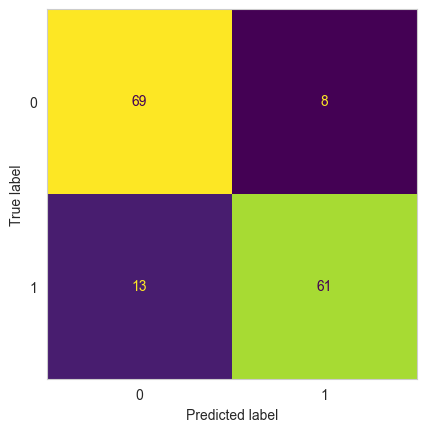

In [20]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=8, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

Index(['danceability', 'energy', 'speechiness', 'liveness', 'key_5'], dtype='object')
Accuracy: 84.11%
Precision: 87.88%
Recall: 78.38%
Cohen's Kappa Score: 0.68


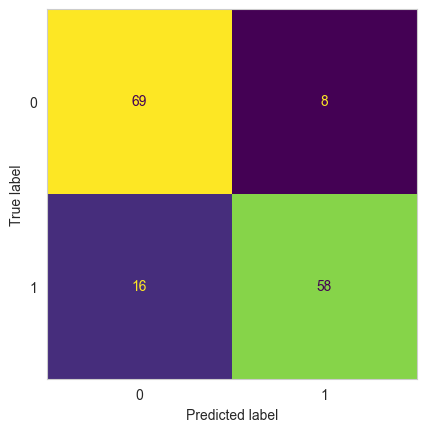

In [21]:
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=5, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

ConfusionMatrixDisplay.from_estimator(model, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

### We can see that the different "key" values play an important role in improving the recall rate of the predictions, i.e. correctly classifying "Like"


# <span style="color:red">Intermediate conclusions</span>

### At this point, I have the following interpretation:
1. The outcome of the model "accuracy" on the test split is *higly!!* dependent on the randomization seed when splitting the data into train/test sets.
2. The combination of logit transform and scaling has a good effect on recall and overall accuracy (did a cross-check separately step-by-step with each pre-processing measure).
3. Checking for correlation among independent variables and proactively removing dependent features is not needed, backward feature selection works well.
4. Reducing the number of features only marginally reduce accuracy, thus it is highly desired to reduce the number of features to improve generalization and avoid overfitting. 
5. To improve the model, tuning hyperparameters can be attempted.


## Hyperparameter tuning

Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'key_5', 'key_6'],
      dtype='object')
Accuracy: 86.09%
Precision: 88.41%
Recall: 82.43%
Cohen's Kappa Score: 0.72
Regularization parameter (C): 1
Gamma value: 0.18868238580532248


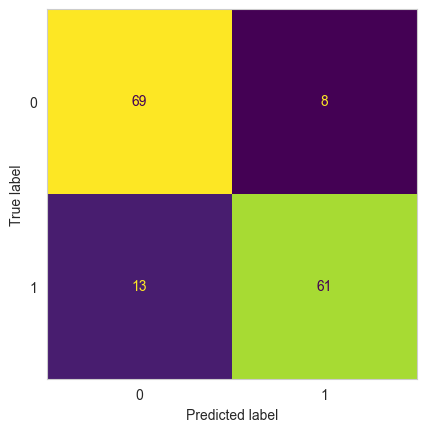

In [22]:
# model with 8 features
sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=8, direction='backward')
sfs.fit(predictors_train, response_train)

selected_features = sfs.get_support()  # Boolean mask of selected features    
predictors_train_sfs = predictors_train.loc[:, selected_features]
predictors_test_sfs = predictors_test.loc[:, selected_features]
print(predictors_test_sfs.columns)

model_best, _ = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test)

# Print out the regularization parameter and gamma value
n_features = predictors_train_sfs.shape[1]
X_variance = predictors_train_sfs.var().mean()
gamma_value = 1 / (n_features * X_variance)
print(f"Regularization parameter (C): {model_best.C}")
print(f"Gamma value: {gamma_value}")
ConfusionMatrixDisplay.from_estimator(model_best, predictors_test_sfs, response_test, colorbar=False)
plt.grid(False)

### Accuracy as target

In [23]:
regularization = {}
gamma = {}
# checking different cross-validation split sizes
for i in range(2, 8):
    print(f'Optimization with cv = {i}')
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient
    }
    
    grid_search = GridSearchCV(model_best, param_grid, scoring='accuracy', n_jobs=-1, cv=i)  # -1 means using all processors in parallel
    grid_search.fit(predictors_train_sfs, response_train)
    
    # Get the best model from the grid search
    best_svm_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    response_pred_rbf_best = best_svm_model.predict(predictors_test_sfs)
    
    # Evaluate the tuning result
    accuracy = accuracy_score(response_test, response_pred_rbf_best)
    precision = precision_score(response_test, response_pred_rbf_best)
    recall = recall_score(response_test, response_pred_rbf_best)
    kappa = cohen_kappa_score(response_test, response_pred_rbf_best)
    
    regularization[i] = grid_search.best_params_['C']
    gamma[i] = grid_search.best_params_['gamma']
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Cohen's Kappa Score: {kappa:.2f}")
    print('\n')
    # ConfusionMatrixDisplay.from_estimator(best_svm_model, predictors_test_sfs, response_test, colorbar=False)
    #plt.grid(False)

print(f'C values: {regularization}')
print(f'gamma values: {gamma}')

Optimization with cv = 2
Best parameters: {'C': 10, 'gamma': 0.1}
Accuracy: 84.11%
Precision: 86.76%
Recall: 79.73%
Cohen's Kappa Score: 0.68


Optimization with cv = 3
Best parameters: {'C': 1, 'gamma': 1}
Accuracy: 81.46%
Precision: 80.26%
Recall: 82.43%
Cohen's Kappa Score: 0.63


Optimization with cv = 4
Best parameters: {'C': 1, 'gamma': 0.1}
Accuracy: 83.44%
Precision: 87.69%
Recall: 77.03%
Cohen's Kappa Score: 0.67


Optimization with cv = 5
Best parameters: {'C': 10, 'gamma': 0.1}
Accuracy: 84.11%
Precision: 86.76%
Recall: 79.73%
Cohen's Kappa Score: 0.68


Optimization with cv = 6
Best parameters: {'C': 100, 'gamma': 0.01}
Accuracy: 81.46%
Precision: 85.94%
Recall: 74.32%
Cohen's Kappa Score: 0.63


Optimization with cv = 7
Best parameters: {'C': 10, 'gamma': 0.1}
Accuracy: 84.11%
Precision: 86.76%
Recall: 79.73%
Cohen's Kappa Score: 0.68


C values: {2: 10, 3: 1, 4: 1, 5: 10, 6: 100, 7: 10}
gamma values: {2: 0.1, 3: 1, 4: 0.1, 5: 0.1, 6: 0.01, 7: 0.1}


#### Note: GridSearchCV uses a 5-fold cross-validation as default to evaluate the different parameter combos. We might have a "lucky" split with the train/test data, hence checking with different cv values to check how the optimum hyperparameters converge.

#### <span style="color:red">Compared to the initial values of C=1, gamma=0.19, the optimum (with lower accuracy) was found at C=10 and gamma = 0.1. Another round to find optimum around those numbers:</span>

In [24]:
regularization = {}
gamma = {}
# checking different cross-validation split sizes
for i in range(2, 8):
    print(f'Optimization with cv = {i}')
    param_grid = {
        'C': [0.4, 0.6 , 0.8, 10, 20, 40, 60],  # Regularization parameter
        'gamma': [0.04, 0.06 , 0.08, 0.1, 0.2, 0.4, 0.6]  # Kernel coefficient
    }
    
    grid_search = GridSearchCV(model_best, param_grid, scoring='accuracy', n_jobs=-1, cv=i)  # -1 means using all processors in parallel
    grid_search.fit(predictors_train_sfs, response_train)
    
    # Get the best model from the grid search
    best_svm_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    response_pred_rbf_best = best_svm_model.predict(predictors_test_sfs)
    
    # Evaluate the tuning result
    accuracy = accuracy_score(response_test, response_pred_rbf_best)
    precision = precision_score(response_test, response_pred_rbf_best)
    recall = recall_score(response_test, response_pred_rbf_best)
    kappa = cohen_kappa_score(response_test, response_pred_rbf_best)
    
    regularization[i] = grid_search.best_params_['C']
    gamma[i] = grid_search.best_params_['gamma']
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Cohen's Kappa Score: {kappa:.2f}")
    print('\n')
    # ConfusionMatrixDisplay.from_estimator(best_svm_model, predictors_test_sfs, response_test, colorbar=False)
    #plt.grid(False)

print(f'C values: {regularization}')
print(f'gamma values: {gamma}')

Optimization with cv = 2
Best parameters: {'C': 10, 'gamma': 0.08}
Accuracy: 82.78%
Precision: 86.36%
Recall: 77.03%
Cohen's Kappa Score: 0.65


Optimization with cv = 3
Best parameters: {'C': 0.4, 'gamma': 0.1}
Accuracy: 82.78%
Precision: 87.50%
Recall: 75.68%
Cohen's Kappa Score: 0.65


Optimization with cv = 4
Best parameters: {'C': 10, 'gamma': 0.06}
Accuracy: 80.79%
Precision: 83.58%
Recall: 75.68%
Cohen's Kappa Score: 0.62


Optimization with cv = 5
Best parameters: {'C': 10, 'gamma': 0.1}
Accuracy: 84.11%
Precision: 86.76%
Recall: 79.73%
Cohen's Kappa Score: 0.68


Optimization with cv = 6
Best parameters: {'C': 0.4, 'gamma': 0.06}
Accuracy: 79.47%
Precision: 85.25%
Recall: 70.27%
Cohen's Kappa Score: 0.59


Optimization with cv = 7
Best parameters: {'C': 20, 'gamma': 0.06}
Accuracy: 83.44%
Precision: 86.57%
Recall: 78.38%
Cohen's Kappa Score: 0.67


C values: {2: 10, 3: 0.4, 4: 10, 5: 10, 6: 0.4, 7: 20}
gamma values: {2: 0.08, 3: 0.1, 4: 0.06, 5: 0.1, 6: 0.06, 7: 0.06}


### Attempting to find a trend between selected features and accuracies across feature set sizes and randomization seed, while also comparing the performance of default hyperparameters with the performance when adjusting gamma and C. This is to avoid inflating the confidence in a model's accuracy based on the performance on a random small test set.

In [26]:
# Basically I loop through the values of how many features we want to keep with backward feature selection. I choose 8 as minimum number of features.
# Second loop is going through an arbitrary number of different seed values to see how much it affects the outcome.

accuracy_orig_dict = {}
accuracy_mod1_dict = {}
accuracy_mod2_dict = {}
accuracy_mod3_dict = {}
accuracy_mod4_dict = {}
bestfeatures = {}
for i in range(1, predictors_train.shape[1] + 1):
    bestfeatures[i] = {}
    accuracy_orig_dict[i] = {}
    accuracy_mod1_dict[i] = {}
    accuracy_mod2_dict[i] = {}
    accuracy_mod3_dict[i] = {}
    accuracy_mod4_dict[i] = {}
    for j in range(50):
        if i == predictors_train.shape[1]:
            seed = j*2
            print(f'{i} features, seed = {seed}')
            predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)
            bestfeatures[i][seed] = predictors_test.columns
            model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test)
            n_features = predictors_train.shape[1]
            X_variance = predictors_train.var().mean()
            gamma_value = 1 / (n_features * X_variance)
            
            _, accuracy_mod1 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 10, gamma = gamma_value/ 2, metrics='None')
            _, accuracy_mod2 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 10, gamma = gamma_value / 4, metrics='None')
            _, accuracy_mod3 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 15, gamma = gamma_value / 2, metrics='None')
            _, accuracy_mod4 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 15, gamma = gamma_value / 4, metrics='None')
            
            accuracy_orig_dict[i][seed] = accuracy
            accuracy_mod1_dict[i][seed] = accuracy_mod1
            accuracy_mod2_dict[i][seed] = accuracy_mod2
            accuracy_mod3_dict[i][seed] = accuracy_mod3
            accuracy_mod4_dict[i][seed] = accuracy_mod4
        else:
            seed = j*2
            print(f'{i} features, seed = {seed}')
            predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)  # increasing test size
            
            sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')
            sfs.fit(predictors_train, response_train)
            
            selected_features = sfs.get_support()  # Boolean mask of selected features    
            predictors_train_sfs = predictors_train.loc[:, selected_features]
            predictors_test_sfs = predictors_test.loc[:, selected_features]
            
            bestfeatures[i][seed] = predictors_test_sfs.columns
            
            model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics='None')
            
            n_features = predictors_train_sfs.shape[1]
            X_variance = predictors_train_sfs.var().mean()
            gamma_value = 1 / (n_features * X_variance)
            
            _, accuracy_mod1 = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = 10, gamma = gamma_value/2, metrics='None')
            _, accuracy_mod2 = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = 10, gamma = gamma_value / 4, metrics='None')
            _, accuracy_mod3 = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = 15, gamma = gamma_value / 2, metrics='None')
            _, accuracy_mod4 = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c = 15, gamma = gamma_value / 4, metrics='None')
            
            accuracy_orig_dict[i][seed] = accuracy
            accuracy_mod1_dict[i][seed] = accuracy_mod1
            accuracy_mod2_dict[i][seed] = accuracy_mod2
            accuracy_mod3_dict[i][seed] = accuracy_mod3
            accuracy_mod4_dict[i][seed] = accuracy_mod4
    

1 features, seed = 0
1 features, seed = 2
1 features, seed = 4
1 features, seed = 6
1 features, seed = 8
1 features, seed = 10
1 features, seed = 12
1 features, seed = 14
1 features, seed = 16
1 features, seed = 18
1 features, seed = 20
1 features, seed = 22
1 features, seed = 24
1 features, seed = 26
1 features, seed = 28
1 features, seed = 30
1 features, seed = 32
1 features, seed = 34
1 features, seed = 36
1 features, seed = 38
1 features, seed = 40
1 features, seed = 42
1 features, seed = 44
1 features, seed = 46
1 features, seed = 48
1 features, seed = 50
1 features, seed = 52
1 features, seed = 54
1 features, seed = 56
1 features, seed = 58
1 features, seed = 60
1 features, seed = 62
1 features, seed = 64
1 features, seed = 66
1 features, seed = 68
1 features, seed = 70
1 features, seed = 72
1 features, seed = 74
1 features, seed = 76
1 features, seed = 78
1 features, seed = 80
1 features, seed = 82
1 features, seed = 84
1 features, seed = 86
1 features, seed = 88
1 features, see

In [36]:
i = 21
for j in range(50):
    seed = j*2
    print(f'{i} features, seed = {seed}')
    predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=seed)
    bestfeatures[i][seed] = predictors_test.columns
    model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, metrics = 'None')
    n_features = predictors_train.shape[1]
    X_variance = predictors_train.var().mean()
    gamma_value = 1 / (n_features * X_variance)
    
    _, accuracy_mod1 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 10, gamma = gamma_value/ 2, metrics='None')
    _, accuracy_mod2 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 10, gamma = gamma_value / 4, metrics='None')
    _, accuracy_mod3 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 15, gamma = gamma_value / 2, metrics='None')
    _, accuracy_mod4 = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c = 15, gamma = gamma_value / 4, metrics='None')
    
    accuracy_orig_dict[i][seed] = accuracy
    accuracy_mod1_dict[i][seed] = accuracy_mod1
    accuracy_mod2_dict[i][seed] = accuracy_mod2
    accuracy_mod3_dict[i][seed] = accuracy_mod3
    accuracy_mod4_dict[i][seed] = accuracy_mod4

21 features, seed = 0
21 features, seed = 2
21 features, seed = 4
21 features, seed = 6
21 features, seed = 8
21 features, seed = 10
21 features, seed = 12
21 features, seed = 14
21 features, seed = 16
21 features, seed = 18
21 features, seed = 20
21 features, seed = 22
21 features, seed = 24
21 features, seed = 26
21 features, seed = 28
21 features, seed = 30
21 features, seed = 32
21 features, seed = 34
21 features, seed = 36
21 features, seed = 38
21 features, seed = 40
21 features, seed = 42
21 features, seed = 44
21 features, seed = 46
21 features, seed = 48
21 features, seed = 50
21 features, seed = 52
21 features, seed = 54
21 features, seed = 56
21 features, seed = 58
21 features, seed = 60
21 features, seed = 62
21 features, seed = 64
21 features, seed = 66
21 features, seed = 68
21 features, seed = 70
21 features, seed = 72
21 features, seed = 74
21 features, seed = 76
21 features, seed = 78
21 features, seed = 80
21 features, seed = 82
21 features, seed = 84
21 features, see

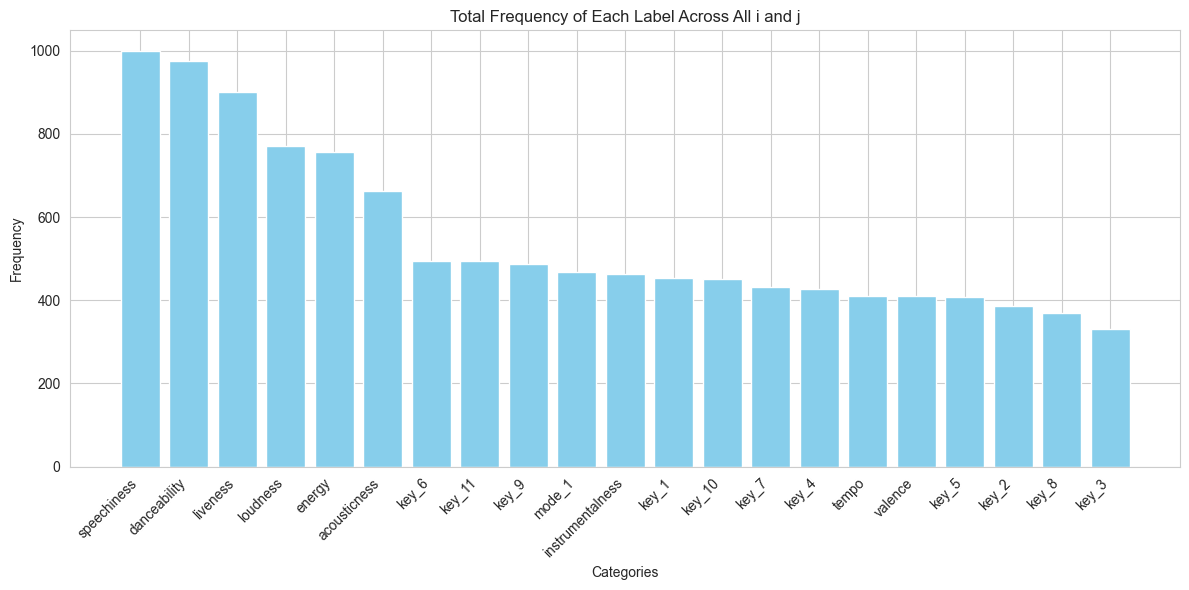

In [37]:
all_features = []
for feature in bestfeatures:
    for seed in bestfeatures[feature]:
        all_features.extend(bestfeatures[feature][seed])

feature_counts = Counter(all_features)

features = list(feature_counts.keys())
frequencies = [feature_counts[feature] for feature in features]

sorted_categories = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Total Frequency of Each Label Across All i and j')
plt.tight_layout()
plt.show()

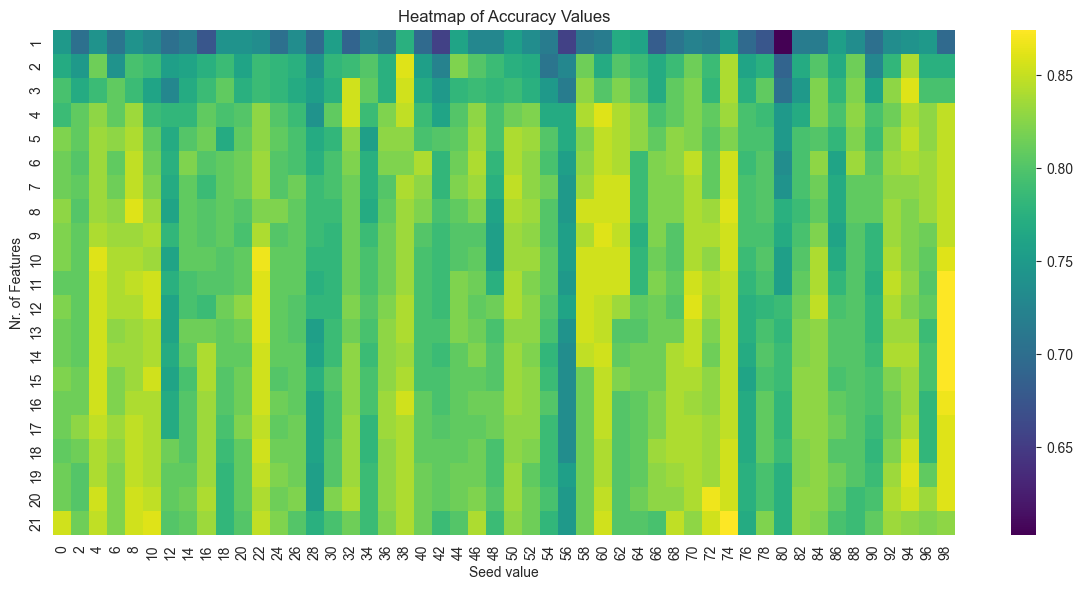

Default max. accuracy: 0.8741721854304636
Default avg. accuracy: 0.8062125512456638


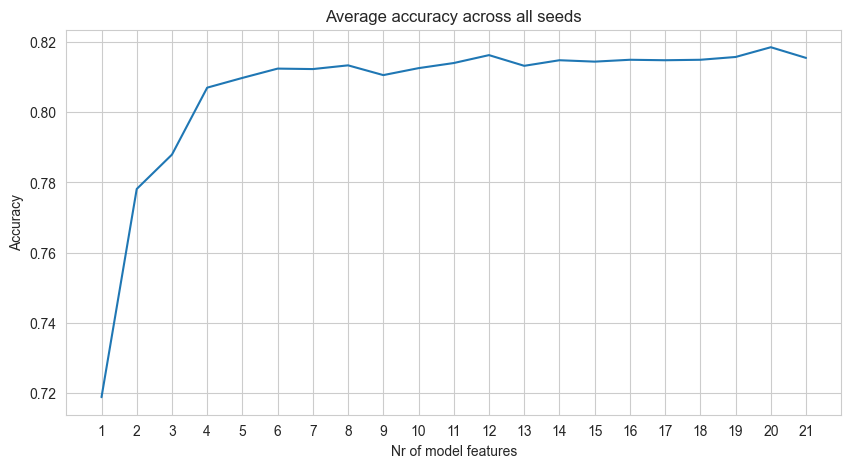

In [56]:
# default parameters
n_features = sorted(accuracy_orig_dict.keys())
seed_nrs = [2 * j for j in range(50)]
Z = np.array([[accuracy_orig_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('Nr. of Features')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

max_value_orig = max(max(sub_dict.values()) for sub_dict in accuracy_orig_dict.values())
average_value_orig = sum(sum(sub_dict.values()) for sub_dict in accuracy_orig_dict.values()) / sum(len(sub_dict) for sub_dict in accuracy_orig_dict.values())
print(f'Default max. accuracy: {max_value_orig}')
print(f'Default avg. accuracy: {average_value_orig}')

average_dict = {key: sum(values.values()) / len(values) for key, values in accuracy_orig_dict.items()}
keys = list(average_dict.keys())    # Top-level keys (1 to 21)
values = list(average_dict.values())  # Corresponding average values
plt.figure(figsize=(10, 5))
plt.plot(keys, values)
plt.title('Average accuracy across all seeds')
plt.xlabel('Nr of model features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(keys)
plt.show()

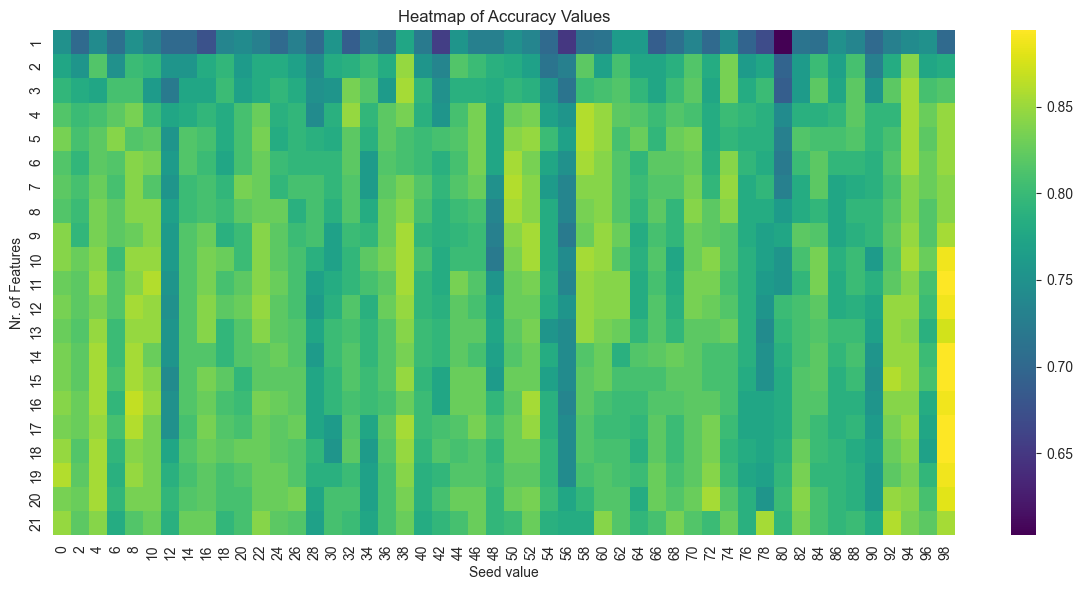

Mod1 max. accuracy: 0.8940397350993378
Mod1 avg. accuracy: 0.8027309996846421


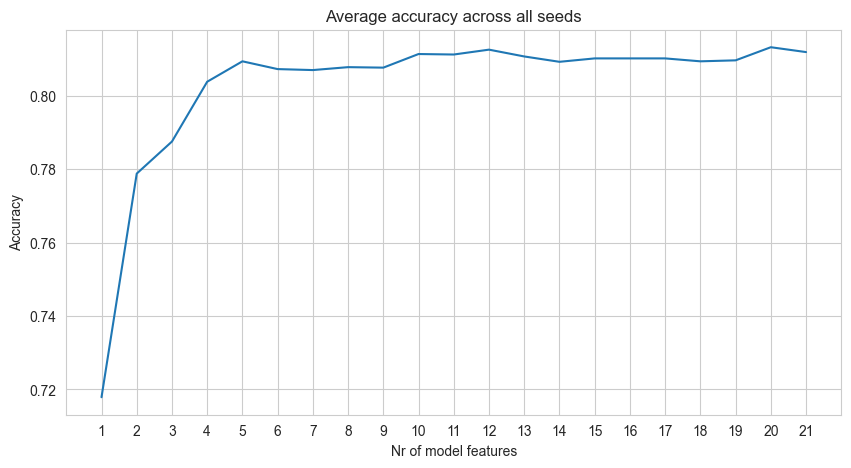

In [57]:
# modified parameters 1
n_features = sorted(accuracy_mod1_dict.keys())
seed_nrs = [2 * j for j in range(50)]
Z = np.array([[accuracy_mod1_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('Nr. of Features')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

max_value_mod1 = max(max(sub_dict.values()) for sub_dict in accuracy_mod1_dict.values())
average_value_mod1 = sum(sum(sub_dict.values()) for sub_dict in accuracy_mod1_dict.values()) / sum(len(sub_dict) for sub_dict in accuracy_mod1_dict.values())
print(f'Mod1 max. accuracy: {max_value_mod1}')
print(f'Mod1 avg. accuracy: {average_value_mod1}')

average_dict = {key: sum(values.values()) / len(values) for key, values in accuracy_mod1_dict.items()}
keys = list(average_dict.keys())
values = list(average_dict.values())
plt.figure(figsize=(10, 5))
plt.plot(keys, values)
plt.title('Average accuracy across all seeds')
plt.xlabel('Nr of model features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(keys)
plt.show()

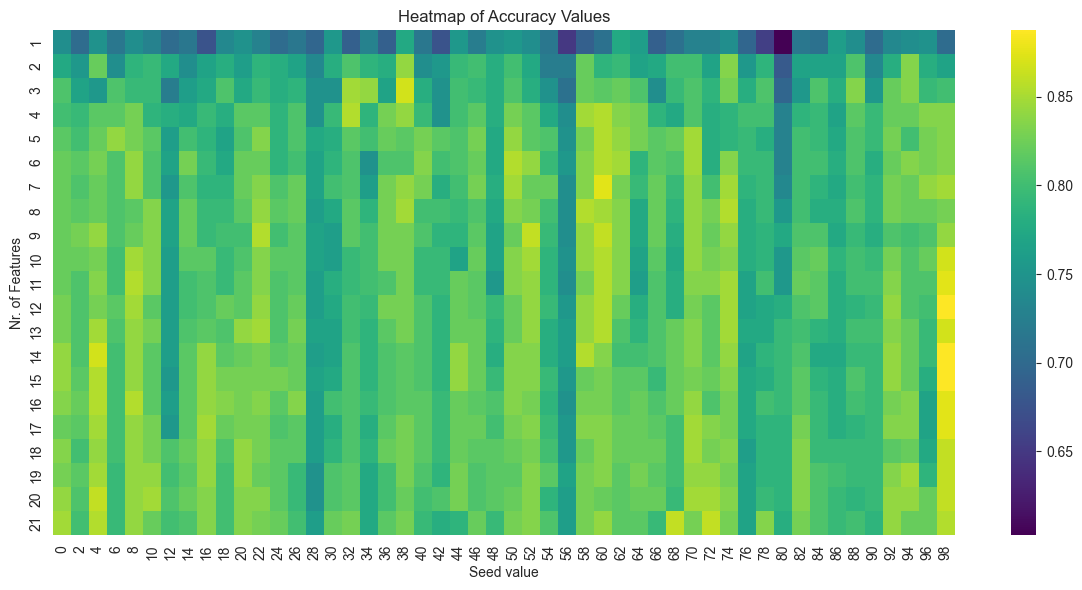

Mod2 max. accuracy: 0.8874172185430463
Mod2 avg. accuracy: 0.8030274361400189


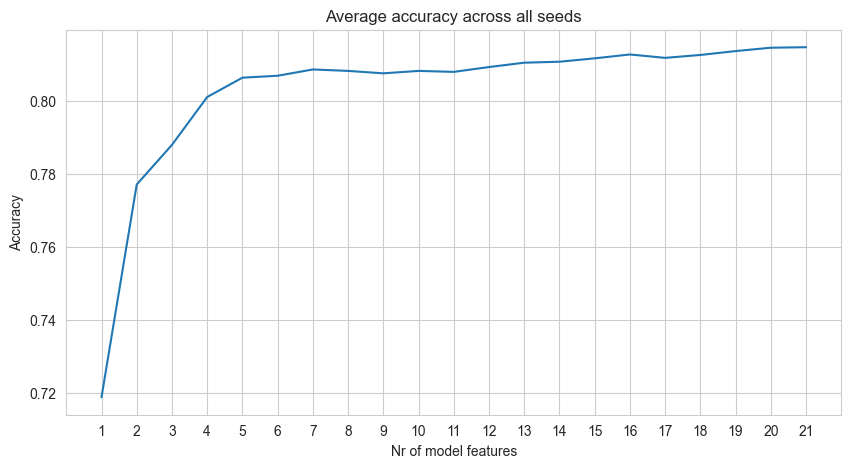

In [58]:
# modified parameters 2
n_features = sorted(accuracy_mod2_dict.keys())
seed_nrs = [2 * j for j in range(50)]
Z = np.array([[accuracy_mod2_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('Nr. of Features')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

max_value_mod2 = max(max(sub_dict.values()) for sub_dict in accuracy_mod2_dict.values())
average_value_mod2 = sum(sum(sub_dict.values()) for sub_dict in accuracy_mod2_dict.values()) / sum(len(sub_dict) for sub_dict in accuracy_mod2_dict.values())
print(f'Mod2 max. accuracy: {max_value_mod2}')
print(f'Mod2 avg. accuracy: {average_value_mod2}')

average_dict = {key: sum(values.values()) / len(values) for key, values in accuracy_mod2_dict.items()}
keys = list(average_dict.keys())
values = list(average_dict.values())
plt.figure(figsize=(10, 5))
plt.plot(keys, values)
plt.title('Average accuracy across all seeds')
plt.xlabel('Nr of model features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(keys)
plt.show()

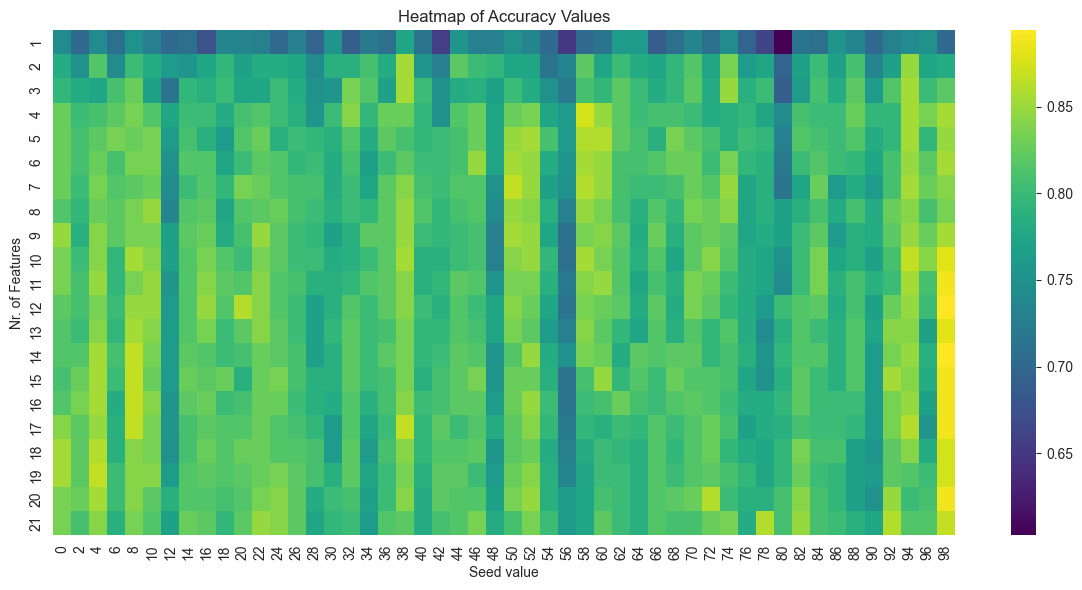

Mod3 max. accuracy: 0.8940397350993378
Mod3 avg. accuracy: 0.8018290760012614


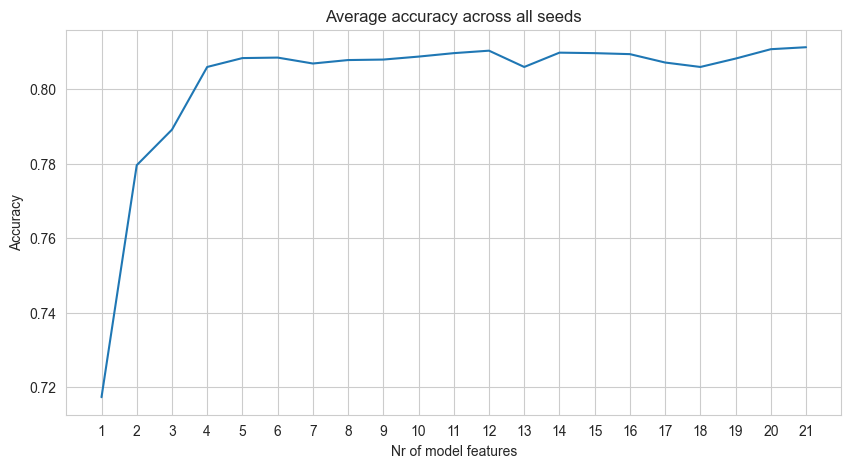

In [59]:
# modified parameters 3
n_features = sorted(accuracy_mod3_dict.keys())
seed_nrs = [2 * j for j in range(50)]
Z = np.array([[accuracy_mod3_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('Nr. of Features')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

max_value_mod3 = max(max(sub_dict.values()) for sub_dict in accuracy_mod3_dict.values())
average_value_mod3 = sum(sum(sub_dict.values()) for sub_dict in accuracy_mod3_dict.values()) / sum(len(sub_dict) for sub_dict in accuracy_mod3_dict.values())
print(f'Mod3 max. accuracy: {max_value_mod3}')
print(f'Mod3 avg. accuracy: {average_value_mod3}')

average_dict = {key: sum(values.values()) / len(values) for key, values in accuracy_mod3_dict.items()}
keys = list(average_dict.keys())
values = list(average_dict.values())
plt.figure(figsize=(10, 5))
plt.plot(keys, values)
plt.title('Average accuracy across all seeds')
plt.xlabel('Nr of model features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(keys)
plt.show()

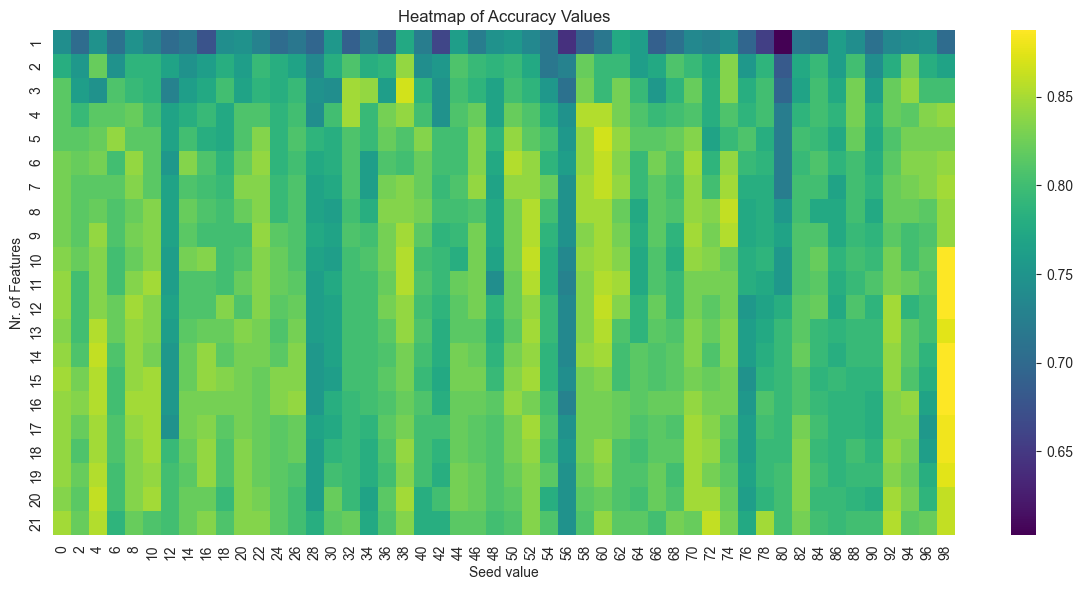

Mod4 max. accuracy: 0.8874172185430463
Mod4 avg. accuracy: 0.8032860296436455


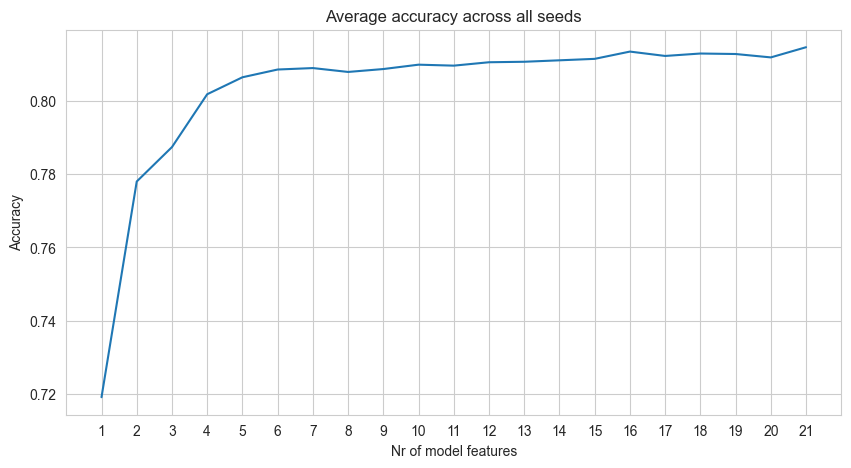

In [60]:
# modified parameters 4
n_features = sorted(accuracy_mod4_dict.keys())
seed_nrs = [2 * j for j in range(50)]
Z = np.array([[accuracy_mod4_dict[n_feature][seed_nr] for n_feature in n_features] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=n_features, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('Nr. of Features')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

max_value_mod4 = max(max(sub_dict.values()) for sub_dict in accuracy_mod4_dict.values())
average_value_mod4 = sum(sum(sub_dict.values()) for sub_dict in accuracy_mod4_dict.values()) / sum(len(sub_dict) for sub_dict in accuracy_mod4_dict.values())
print(f'Mod4 max. accuracy: {max_value_mod4}')
print(f'Mod4 avg. accuracy: {average_value_mod4}')

average_dict = {key: sum(values.values()) / len(values) for key, values in accuracy_mod4_dict.items()}
keys = list(average_dict.keys())
values = list(average_dict.values())
plt.figure(figsize=(10, 5))
plt.plot(keys, values)
plt.title('Average accuracy across all seeds')
plt.xlabel('Nr of model features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(keys)
plt.show()

Default hyperparameters are the best performing. Model performs well already at 4-6 features. Those 4-6 features are the following:

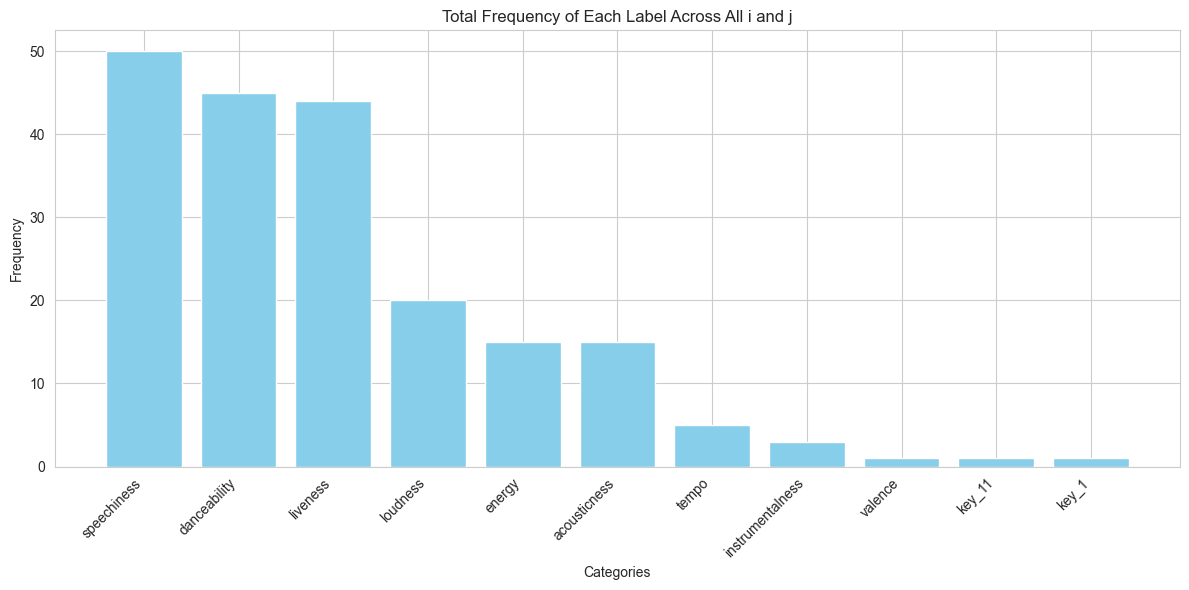

In [62]:
all_features = []

for seed in bestfeatures[4]:
    all_features.extend(bestfeatures[4][seed])

feature_counts = Counter(all_features)

features = list(feature_counts.keys())
frequencies = [feature_counts[feature] for feature in features]

sorted_categories = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Total Frequency of Each Label Across All i and j')
plt.tight_layout()
plt.show()

Index(['danceability', 'loudness', 'speechiness', 'liveness', 'tempo'], dtype='object')


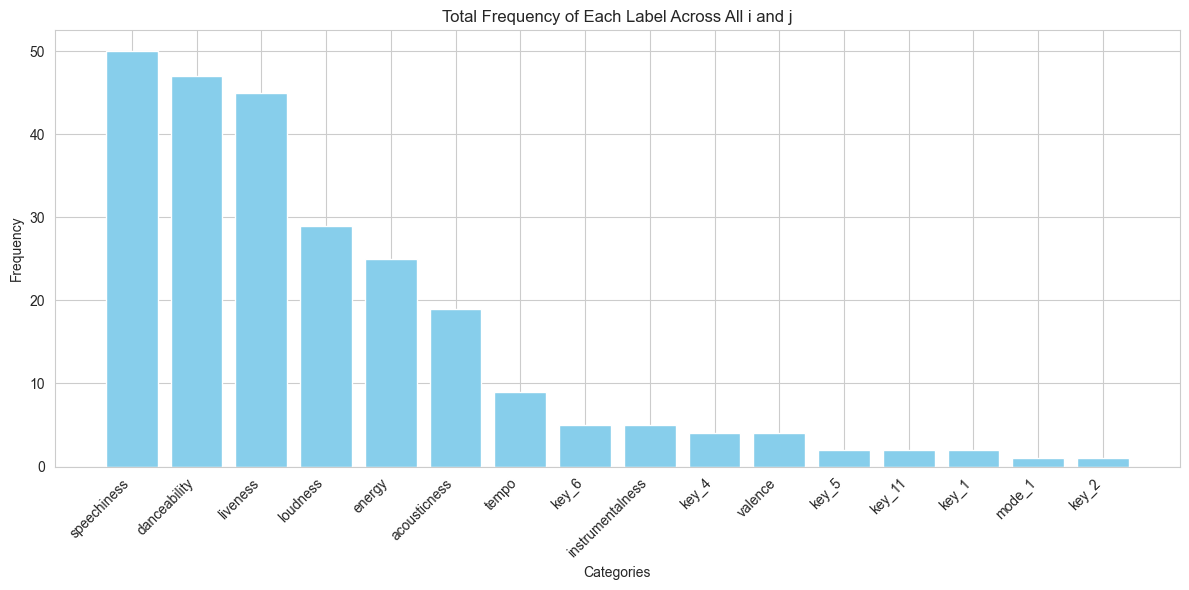

In [63]:
all_features = []

for seed in bestfeatures[5]:
    all_features.extend(bestfeatures[5][seed])
feature_counts = Counter(all_features)

features = list(feature_counts.keys())
frequencies = [feature_counts[feature] for feature in features]

sorted_categories = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Total Frequency of Each Label Across All i and j')
plt.tight_layout()
plt.show()

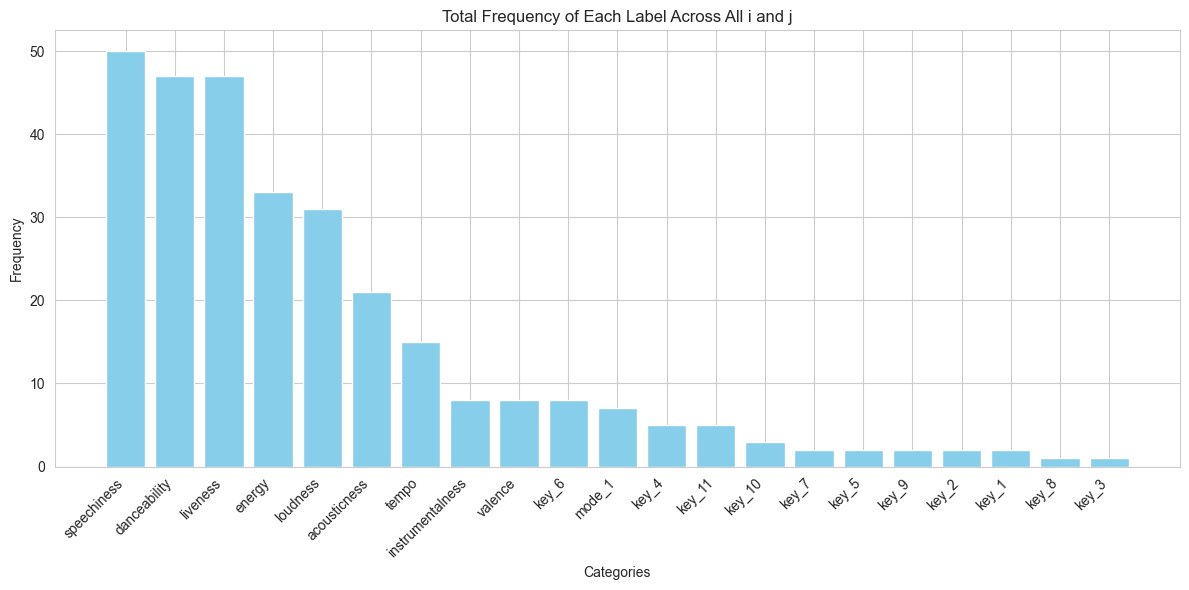

In [64]:
all_features = []

for seed in bestfeatures[6]:
    all_features.extend(bestfeatures[6][seed])
feature_counts = Counter(all_features)

features = list(feature_counts.keys())
frequencies = [feature_counts[feature] for feature in features]

sorted_categories = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Total Frequency of Each Label Across All i and j')
plt.tight_layout()
plt.show()

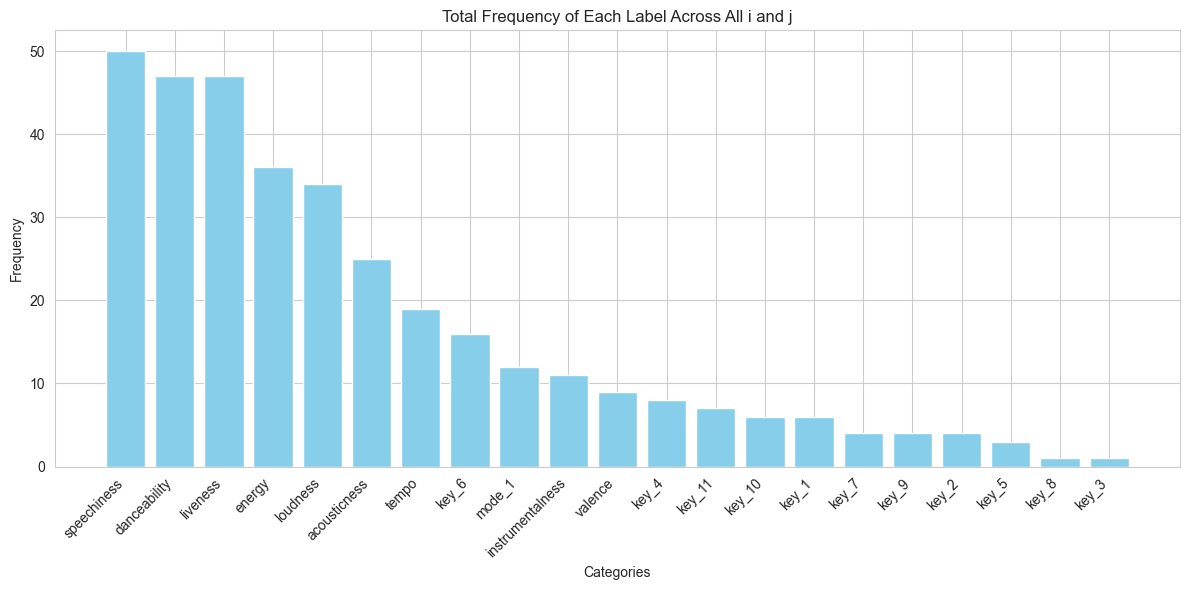

In [65]:
all_features = []

for seed in bestfeatures[7]:
    all_features.extend(bestfeatures[7][seed])
feature_counts = Counter(all_features)

features = list(feature_counts.keys())
frequencies = [feature_counts[feature] for feature in features]

sorted_categories = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Total Frequency of Each Label Across All i and j')
plt.tight_layout()
plt.show()

The more features we try to use, the more diverse the composition of different "best" feature sets are. This is another reason why using fewer features make more sense. I chose 4 features: speechiness, danceability, liveness, loudness

# <span style="color:red">Final model and performance evaluation</span>

In [67]:
final_features = ['speechiness', 'danceability', 'liveness', 'loudness']
accuracy_final_dict = {}
# getting an idea of accuracy:
for i in [10, 20, 30]:
    accuracy_final_dict[i] = {}
    for seed in range(201):
        print(f'Training split: {i/100}, seed = {seed}')
        predictors_train_final, predictors_test_final, response_train_final, response_test_final = train_test_split(encoded_data[final_features], response, test_size=i/100, random_state=seed)
        
        model, accuracy = svm_model('rbf', predictors_train_final, response_train_final, predictors_test_final, response_test_final, metrics = 'None')
        
        accuracy_final_dict[i][seed] = accuracy


Training split: 0.1, seed = 0
Training split: 0.1, seed = 1
Training split: 0.1, seed = 2
Training split: 0.1, seed = 3
Training split: 0.1, seed = 4
Training split: 0.1, seed = 5
Training split: 0.1, seed = 6
Training split: 0.1, seed = 7
Training split: 0.1, seed = 8
Training split: 0.1, seed = 9
Training split: 0.1, seed = 10
Training split: 0.1, seed = 11
Training split: 0.1, seed = 12
Training split: 0.1, seed = 13
Training split: 0.1, seed = 14
Training split: 0.1, seed = 15
Training split: 0.1, seed = 16
Training split: 0.1, seed = 17
Training split: 0.1, seed = 18
Training split: 0.1, seed = 19
Training split: 0.1, seed = 20
Training split: 0.1, seed = 21
Training split: 0.1, seed = 22
Training split: 0.1, seed = 23
Training split: 0.1, seed = 24
Training split: 0.1, seed = 25
Training split: 0.1, seed = 26
Training split: 0.1, seed = 27
Training split: 0.1, seed = 28
Training split: 0.1, seed = 29
Training split: 0.1, seed = 30
Training split: 0.1, seed = 31
Training split: 0.

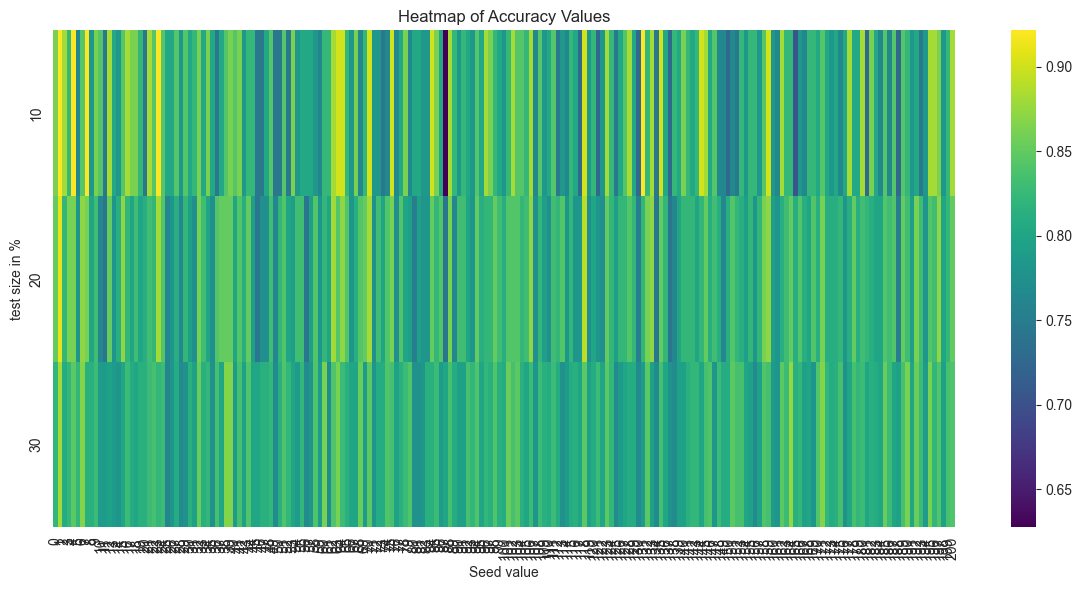

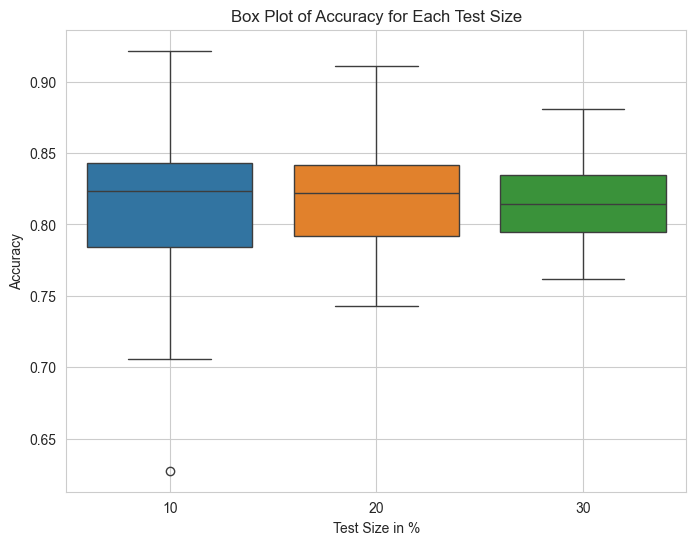

10    0.921569
20    0.910891
30    0.880795
dtype: float64
10    0.627451
20    0.742574
30    0.761589
dtype: float64
10    0.816896
20    0.817398
30    0.813911
dtype: float64


In [76]:
splits = sorted(accuracy_final_dict.keys())
seed_nrs = range(201)
Z = np.array([[accuracy_final_dict[split][seed_nr] for split in splits] for seed_nr in seed_nrs])

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Z.T, xticklabels=seed_nrs, yticklabels=splits, cmap='viridis', annot=False)
plt.xlabel('Seed value')
plt.ylabel('test size in %')
plt.title('Heatmap of Accuracy Values')
plt.tight_layout()
plt.show()

df = pd.DataFrame(accuracy_final_dict)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df)
plt.title('Box Plot of Accuracy for Each Test Size')
plt.xlabel('Test Size in %')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

print(df.max())
print(df.min())
print(df.mean())


Smaller test size with such small database is more prone to "lucky" and "unlucky" splits, thus both the max. and min. accuracy values are in the 10% bracket, and by seeing that the average accuracy drops by increasing the testing set size, we can infer that accuracy is very much dependent on the training set size.